In [ ]:
# Copyright 2024 Google LLC
#
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
#     https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

# Website classification

- Authors: Mandie Quartly, Paul Barnes
- Last updated: 24th June 2024

Using Gemini 1.5 Flash.

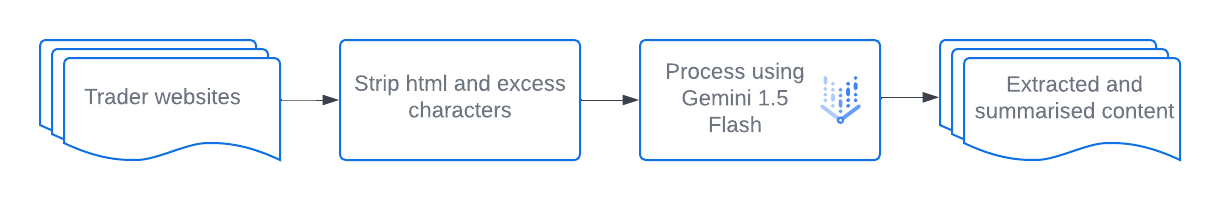

## Environment set up

In [ ]:
# %pip install --upgrade google-cloud-aiplatform markdownify

**Important:** restart kernel if new packages are installed.

In [ ]:
PROJECT_ID = "YOUR_PROJECT_HERE"  # @param {type:"string"}
REGION = "us-central1"  # @param {type: "string"}

In [ ]:
import pandas as pd

import vertexai
vertexai.init(project=PROJECT_ID, location=REGION)
print(f"Using vertexai version: {vertexai.__version__}")

from vertexai.generative_models import (
    FinishReason, 
    GenerationConfig, 
    GenerativeModel, 
    HarmBlockThreshold,
    HarmCategory,
    Image, 
    Part, 
    SafetySetting
)

import os, json
from pathlib import Path
import requests
from urllib.parse import urlparse
from tqdm.notebook import tqdm
tqdm.pandas()

import markdownify
from pprint import pprint

In [ ]:
model = GenerativeModel("gemini-1.5-flash-001")
# model = GenerativeModel("gemini-1.5-pro-001")

In [ ]:
generation_config = GenerationConfig(
    temperature=0.1,
    response_mime_type="application/json"
)

## Helper functions

In [ ]:
def get_filename_from_url(url):
    """Gets a sanitized filename from a URL."""
    parsed_url = urlparse(url)
    netloc = parsed_url.netloc.replace(".", "_")
    path = parsed_url.path.replace("/", "_")
    filename = netloc+path+".html"

    return filename

In [ ]:
def download_html(url):
    """Downloads the HTML content from the given URL and saves it to a file."""

    directory_path = "html_files/"
    os.makedirs(directory_path, exist_ok=True)

    filename = directory_path+get_filename_from_url(url)
    headers = {
        'User-Agent': 'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/58.0.3029.110 Safari/537.3'
    }
    
    if not os.path.exists(filename):
        try:
            response = requests.get(url, headers=headers)
            response.raise_for_status()  # Raise an exception for bad responses (4xx and 5xx)

            with open(filename, "wb") as f:
                f.write(response.content)

            print(f"Downloaded HTML from {url} and saved to {filename}")
        except requests.RequestException as e:
            print(f"An error occurred while downloading: {e}")
    else:
        print(f"{filename} exists, skipping")
        
    return filename

In [ ]:
def read_html_file(file_path):
    """Reads an HTML file and returns its content as a string."""
    try:
        path = Path(file_path)
        with path.open(mode='r', encoding='utf-8') as file:  # Explicitly set UTF-8 encoding
            html_content = file.read()
        return html_content
    except FileNotFoundError:
        raise FileNotFoundError(f"The file {file_path} was not found.")

In [ ]:
def classify_website(df):
    md_string = markdownify.markdownify(read_html_file(df['local_file']))
    
    response = model.generate_content(prompt_classify+md_string,
                                     generation_config=generation_config)
    input_tokens = response.usage_metadata.prompt_token_count
    output_tokens = response.usage_metadata.candidates_token_count
    # return response.text
    return pd.Series({"classification": response.text, 
                      "input_tokens": input_tokens, 
                      "output_tokens": output_tokens})

## Load test websites

In [ ]:
website_list = [
    "add your URLS list here",
    "another URL"
]

In [ ]:
sites = []
for site in website_list:
    output_file = download_html(site)
    sites.append({
        "url": site,
        "local_file": output_file
    })

df_websites = pd.DataFrame(sites)

In [ ]:
# df_websites

## Process sites using Gemini

In [ ]:
sample_json_1 = {
    "company_name": "Jones Electrics",
    "primary_trade": "electrician",
    "secondary_trade": "NA",
    "email" : "enquires@example.com",
    "phone" : "07775555555",
    "address" : "1 New Road, Newtown, Derbyshire, DE1 1AA",
    "summary": "A local electrican who is happy to help.",
    "comments": "All details found in site"
}

sample_json_2 = {
    "company_name": "Ali",
    "primary_trade": "gardener",
    "secondary_trade": "builder",
    "email" : "hello@bump.com",
    "phone" : "NA",
    "address" : "London",
    "summary": "Ali has a background in various areas, including gardening and building.",
    "comments": "No phone number available"
  }

prompt_classify = f"""
Extract the following information from the following input document:
- company_name
- primary_trade (for example plumber, electrician, builder, brick layer, gardener or other as found)
- secondary_trade (where available, otherwise state NA)
- email
- phone (note if more than one available in comments and why this one was chosen)
- address (with as many details as are available, just town or county is acceptable, NA if not found)
- summary (a one paragraph summary of the website for introducing this company)
- comments (note any issues in gathering the above information)

Give the output in plain text JSON format. 
Only use information seen in the input document, otherwise mark as NA. 

Example output 1:
{sample_json_1}

Example output 2:
{sample_json_2}

Input document:
"""

In [ ]:
new_cols = ['classification', 'input_tokens', 'output_tokens']
df_websites[new_cols] = df_websites.progress_apply(classify_website, axis=1)

In [ ]:
# pd.set_option('display.max_colwidth', None)
df_websites[['url', 'classification','input_tokens', 'output_tokens']]

In [ ]:
for index, row in df_websites.iterrows():
    print("\nWebsite classified", row.url)
    pprint(json.loads(row.classification), sort_dicts=False)